In [15]:
!pip install -q yfinance
!pip install -q pandas_datareader
!pip install -q tensorflow
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q numpy
!pip install -q keras
!pip install -q pmdarima
!pip install -q optuna
!pip install -q prophet

In [16]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [17]:
# Download stock data
stock_data = yf.download('AAPL', period='3y') # Get 3 years of data directly
num_days_pred = 30 # Number of days you want to predict in the future

[*********************100%***********************]  1 of 1 completed


In [18]:
# Check what columns we actually have
print("Available columns:", stock_data.columns.tolist())
print("Data shape:", stock_data.shape)

# Fix MultiIndex columns - flatten them
stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]
print("Flattened columns:", stock_data.columns.tolist())

# Keep only the Close column
stock_data = stock_data[['Close_AAPL']].copy()
stock_data.rename(columns={'Close_AAPL': 'Close'}, inplace=True)

print("Final columns:", stock_data.columns.tolist())
print("Data shape:", stock_data.shape)
print("Data head:")
print(stock_data.head())

Available columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Data shape: (752, 5)
Flattened columns: ['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']
Final columns: ['Close']
Data shape: (752, 1)
Data head:
                 Close
Date                  
2022-08-29  158.872116
2022-08-30  156.440521
2022-08-31  154.776794
2022-09-01  155.505310
2022-09-02  153.388687


In [19]:
# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones_like(y_true), np.abs(y_true)))) * 100

def add_lags(df, num_lags=12):
    """Add lag features with a reasonable number of lags"""
    target = 'Close'
    # Use a smaller number of lags based on data size
    max_possible_lags = min(12, len(df) // 10)  # Ensure we have enough data
    for i in range(1, max_possible_lags + 1):
        df[f'lag{i}'] = df[target].shift(i)
    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

# Check if time series is stationary
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05  # Return True if stationary

# XGBoost Model

In [20]:
# XGBOOST Model
df_xgb = stock_data.copy()

def prepare_xgboost_data(df_xgb, add_lags_func, create_features_func):
    df_xgb = create_features_func(df_xgb)
    df_xgb = add_lags_func(df_xgb)
    df_xgb.dropna(inplace=True)  # Drop rows with NaN values created by lagging

    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X, y

# Prepare data for XGBoost
X, y = prepare_xgboost_data(df_xgb, add_lags, create_features)

print(f"X shape: {X.shape}, y shape: {y.shape}")

if len(X) == 0:
    print("Not enough data for XGBoost modeling. Using simpler approaches.")

    # Fallback: Use only basic features without lags
    df_xgb_simple = create_features(stock_data.copy())
    X = df_xgb_simple.drop(columns='Close')
    y = df_xgb_simple['Close']
    print(f"Using simple features. X shape: {X.shape}, y shape: {y.shape}")

X shape: (740, 18), y shape: (740,)


In [21]:
# Initialize variables for later use
xgb_loss = float('inf')
xgb_best = None
X_train, X_test, y_train, y_test = None, None, None, None

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': 0,
    }

    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

[I 2025-08-28 08:24:30,405] A new study created in memory with name: no-name-cd3f91cd-0a87-4528-a3d4-e3153e0e017c


Train shape: (518, 18), Test shape: (222, 18)


[I 2025-08-28 08:24:30,674] Trial 0 finished with value: 13.768353323081083 and parameters: {'n_estimators': 69, 'max_depth': 5, 'learning_rate': 0.053835616713180975, 'subsample': 0.7566729266485032, 'colsample_bytree': 0.7263538607848793}. Best is trial 0 with value: 13.768353323081083.
[I 2025-08-28 08:24:30,822] Trial 1 finished with value: 12.816107439910065 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.09866743259402526, 'subsample': 0.7604795549109332, 'colsample_bytree': 0.9215258695485258}. Best is trial 1 with value: 12.816107439910065.
[I 2025-08-28 08:24:31,147] Trial 2 finished with value: 14.618340431905157 and parameters: {'n_estimators': 58, 'max_depth': 4, 'learning_rate': 0.04317171322413585, 'subsample': 0.8737920630275271, 'colsample_bytree': 0.7354978337133093}. Best is trial 1 with value: 12.816107439910065.
[I 2025-08-28 08:24:31,285] Trial 3 finished with value: 11.880018665151303 and parameters: {'n_estimators': 185, 'max_depth': 3, '

Best trial:
  Value: 11.880018665151303
  Params: 
    n_estimators: 185
    max_depth: 3
    learning_rate: 0.06216937438170458
    subsample: 0.7859788438827698
    colsample_bytree: 0.879221397365448
Test RMSE: 11.880018665151303
XGBoost ERROR PERCENT = 3.65% 


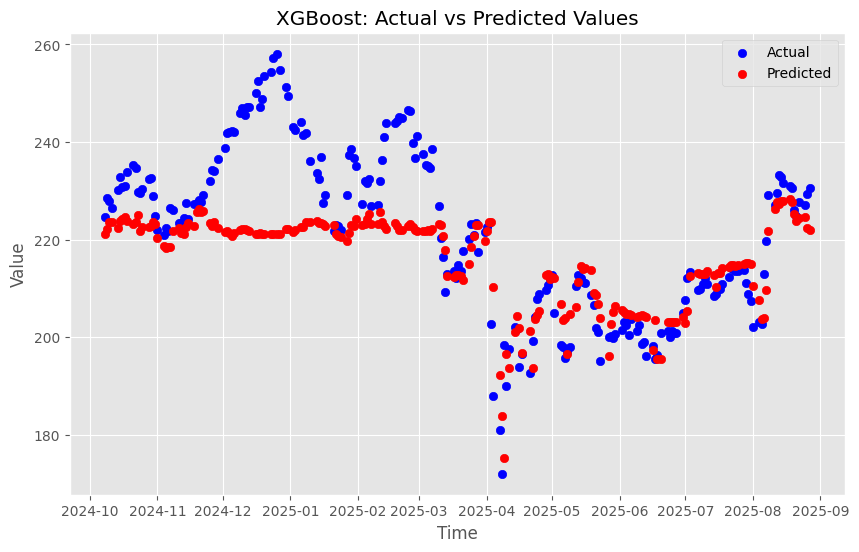

In [22]:
# Split data for training and testing
if len(X) > 10:  # Ensure we have enough data for splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # Perform hyperparameter optimization using Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=5)  # Reduced trials for faster execution

    # Print the best trial and parameters found
    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # Use the best parameters to train the final model
    best_params = best_trial.params
    xgb_best = XGBRegressor(**best_params)
    xgb_best.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = xgb_best.predict(X_test)

    # Calculate RMSE on the test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print("Test RMSE:", rmse_test)

    # Evaluate
    y_pred_test_xgb = xgb_best.predict(X_test)
    xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb)
    print(f"XGBoost ERROR PERCENT = {xgb_loss:.2f}% ")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test.index, y_test, color='blue', label='Actual')
    plt.scatter(X_test.index, y_pred_test_xgb, color='red', label='Predicted')
    plt.title('XGBoost: Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

else:
    print("Not enough data for XGBoost training. Skipping XGBoost model.")
    xgb_loss = float('inf')

# Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpthzj22mv/vz1bke4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpthzj22mv/gcwp0eg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57906', 'data', 'file=/tmp/tmpthzj22mv/vz1bke4o.json', 'init=/tmp/tmpthzj22mv/gcwp0eg6.json', 'output', 'file=/tmp/tmpthzj22mv/prophet_modelo2p397do/prophet_model-20250828082431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:24:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:24:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet ERROR PERCENT = 31.71% 


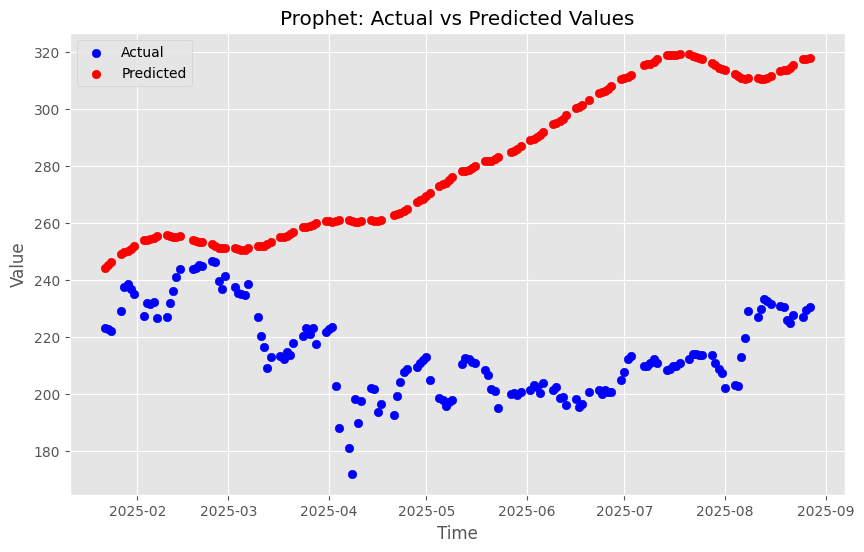

In [23]:
# Prophet Model
df_prophet = stock_data.copy()

# Split
split_idx = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:split_idx].copy()
test = df_prophet.iloc[split_idx:].copy()

# Preprocess
train_prophet = train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# Training
prophet = Prophet()
prophet.fit(train_prophet)

# Format data for prophet model using ds and y
test_prophet = test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
test_predict = prophet.predict(test_prophet)

# Evaluating
prophet_loss = mean_absolute_percentage_error(test['Close'], test_predict['yhat'])
print(f"Prophet ERROR PERCENT = {prophet_loss:.2f}% ")

plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['Close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'], color='red', label='Predicted')
plt.title('Prophet: Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [24]:
# Predicting in the Future with Prophet
prophet_data = df_prophet.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet = Prophet()
prophet.fit(prophet_data)

future = prophet.make_future_dataframe(periods=num_days_pred, freq='D', include_history=False)
forecast = prophet.predict(future)
forecast_prophet = forecast[['ds', 'yhat']]
forecast_prophet.index = forecast_prophet.pop('ds')

print("Prophet Predictions:")
print(forecast_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpthzj22mv/83jm5zbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpthzj22mv/c5axg1gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44154', 'data', 'file=/tmp/tmpthzj22mv/83jm5zbe.json', 'init=/tmp/tmpthzj22mv/c5axg1gq.json', 'output', 'file=/tmp/tmpthzj22mv/prophet_model7esyttro/prophet_model-20250828082432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:24:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Predictions:
                  yhat
ds                    
2025-08-28  214.876088
2025-08-29  214.727940
2025-08-30  219.081191
2025-08-31  218.555848
2025-09-01  213.266537
2025-09-02  212.542154
2025-09-03  211.694181
2025-09-04  210.941841
2025-09-05  210.490255
2025-09-06  214.600060
2025-09-07  213.894644
2025-09-08  208.490483
2025-09-09  207.716788
2025-09-10  206.883852
2025-09-11  206.208271
2025-09-12  205.891201
2025-09-13  210.188117
2025-09-14  209.716204
2025-09-15  204.584886
2025-09-16  204.115668
2025-09-17  203.610704
2025-09-18  203.278234
2025-09-19  203.311063
2025-09-20  207.956533
2025-09-21  207.824113
2025-09-22  203.016114
2025-09-23  202.847694
2025-09-24  202.615560
2025-09-25  202.523518
2025-09-26  202.761022


# ARIMA Model

In [25]:
# ARIMA Model
df_arima = stock_data.copy()

# Check stationarity
print("Checking stationarity of ARIMA data:")
is_stationary = check_stationarity(df_arima['Close'])
print(f"Is stationary: {is_stationary}")

# Simple ARIMA model
try:
    # Try a simple ARIMA model
    arima = ARIMA(df_arima['Close'], order=(1, 1, 1))
    arima_fit = arima.fit()

    # Forecast
    arima_forecast = arima_fit.forecast(steps=num_days_pred)

    # Create index for forecast
    start_date = df_arima.index[-1] + pd.Timedelta(days=1)
    forecast_dates = pd.date_range(start=start_date, periods=num_days_pred, freq='D')
    arima_forecast_df = pd.DataFrame(arima_forecast, index=forecast_dates, columns=['Close'])

    print("ARIMA Predictions:")
    print(arima_forecast_df)

    # Calculate error if we have test data
    if len(test) > 0:
        # For demonstration, use last few points as test
        test_arima = df_arima['Close'].iloc[-10:]
        pred_arima = arima_fit.predict(start=len(df_arima)-10, end=len(df_arima)-1)
        arima_loss = mean_absolute_percentage_error(test_arima, pred_arima)
        print(f"ARIMA ERROR PERCENT = {arima_loss:.2f}%")
    else:
        arima_loss = float('inf')

except Exception as e:
    print(f"ARIMA model failed: {e}")
    # Create a simple baseline forecast (last value)
    last_value = df_arima['Close'].iloc[-1]
    start_date = df_arima.index[-1] + pd.Timedelta(days=1)
    forecast_dates = pd.date_range(start=start_date, periods=num_days_pred, freq='D')
    arima_forecast_df = pd.DataFrame([last_value] * num_days_pred,
                                    index=forecast_dates, columns=['Close'])
    print("Using last value as ARIMA forecast")
    arima_loss = float('inf')

Checking stationarity of ARIMA data:
ADF Statistic: -1.3067671825188105
p-value: 0.6260706604777327
Critical Values:
   1%: -3.439134355513998
   5%: -2.865416893922985
   10%: -2.56883447171999
Is stationary: False
ARIMA Predictions:
           Close
2025-08-28   NaN
2025-08-29   NaN
2025-08-30   NaN
2025-08-31   NaN
2025-09-01   NaN
2025-09-02   NaN
2025-09-03   NaN
2025-09-04   NaN
2025-09-05   NaN
2025-09-06   NaN
2025-09-07   NaN
2025-09-08   NaN
2025-09-09   NaN
2025-09-10   NaN
2025-09-11   NaN
2025-09-12   NaN
2025-09-13   NaN
2025-09-14   NaN
2025-09-15   NaN
2025-09-16   NaN
2025-09-17   NaN
2025-09-18   NaN
2025-09-19   NaN
2025-09-20   NaN
2025-09-21   NaN
2025-09-22   NaN
2025-09-23   NaN
2025-09-24   NaN
2025-09-25   NaN
2025-09-26   NaN
ARIMA ERROR PERCENT = 0.67%


# Model Comparison

In [26]:
# Compare models
print("\nModel Comparison:")
if xgb_loss != float('inf'):
    print(f"XGBoost Accuracy: {100 - xgb_loss:.2f}%")
print(f"Prophet Accuracy: {100 - prophet_loss:.2f}%")
if arima_loss != float('inf'):
    print(f"ARIMA Accuracy: {100 - arima_loss:.2f}%")


Model Comparison:
XGBoost Accuracy: 96.35%
Prophet Accuracy: 68.29%
ARIMA Accuracy: 99.33%


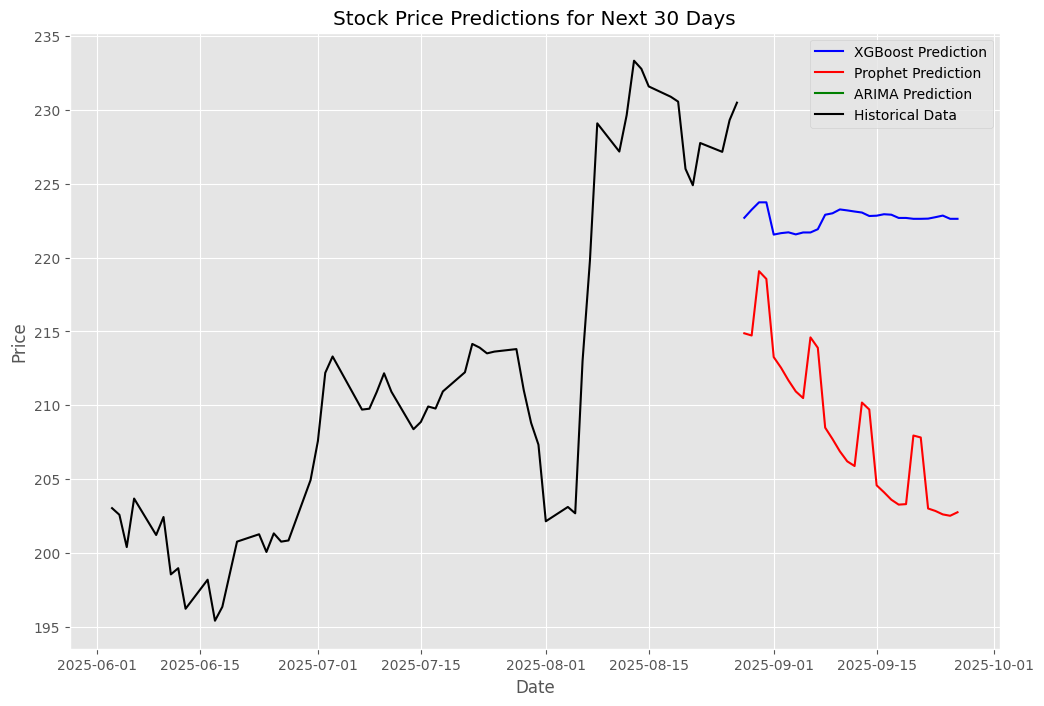

In [27]:
# Create XGBoost future predictions if the model was trained
if xgb_loss != float('inf') and xgb_best is not None:
    # Create future dates for prediction
    last_date = df_xgb.index[-1]
    future_dates = [last_date + pd.Timedelta(days=x) for x in range(1, num_days_pred+1)]

    # Create future dataframe with features
    future_df = pd.DataFrame(index=future_dates)
    future_df = create_features(future_df)

    # Add lags - we need to use the actual data to create the first lags
    for i in range(1, 13):  # Assuming 12 lags as in your add_lags function
        if i <= len(df_xgb):
            future_df[f'lag{i}'] = df_xgb['Close'].iloc[-i]
        else:
            future_df[f'lag{i}'] = np.nan

    # For subsequent predictions, we'd need to use previous predictions
    # This is a simplified approach using only known values
    prediction_xgb = pd.DataFrame({
        'pred': xgb_best.predict(future_df)
    }, index=future_dates)
else:
    prediction_xgb = pd.DataFrame()  # Empty dataframe if XGBoost wasn't trained

# Plot all predictions
plt.figure(figsize=(12, 8))
if not prediction_xgb.empty:
    plt.plot(prediction_xgb.index, prediction_xgb['pred'], 'b-', label='XGBoost Prediction')
plt.plot(forecast_prophet.index, forecast_prophet['yhat'], 'r-', label='Prophet Prediction')
plt.plot(arima_forecast_df.index, arima_forecast_df['Close'], 'g-', label='ARIMA Prediction')
plt.plot(stock_data.index[-60:], stock_data['Close'][-60:], 'k-', label='Historical Data')
plt.title(f'Stock Price Predictions for Next {num_days_pred} Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()